# Homework 1

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2024

# Functions

# Context

For use in these problems, consider the data below, discussed in Veronesi's *Fixed Income Securities* Chapters 9, 10.
* interest-rate tree
* current term structure

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

BASE_DIR = r'C:\Users\Alex\Desktop\Academic\UChicago\FINM 37500\finm-fiderivs-2024'
import sys, os
sys.path.append(BASE_DIR)

from cmds.binomial import *
from cmds.ratecurves import *
from cmds.volskew import *
from cmds.ficcvol import *

In [70]:
dt = .5
T = .5
rate_tree = construct_rate_tree(dt,T)

rate_tree[.5] = [.0339,.0095]
rate_tree.loc[0,0] = .0174
format_bintree(rate_tree,style='{:.2%}')

time,0.00,0.50
state,,
0,1.74%,3.39%
1,,0.95%


In [71]:
rate_tree = pd.DataFrame({0:[.0174,np.nan],0.5:[.0339,.0095]})
rate_tree.columns.name = 'time $t$'
rate_tree.index.name = 'node'
rate_tree.style.format('{:.2%}',na_rep='')

time $t$,0.000000,0.500000
node,,
0,1.74%,3.39%
1,,0.95%


The "tree" is displayed as a pandas dataframe, so it does not list "up" and "down" for the rows but rather an index of nodes. The meaning should be clear.

In [72]:
term_struct = pd.DataFrame({'maturity':[.5,1,1.5],'price':[99.1338,97.8925,96.1462]})
term_struct['continuous ytm'] = -np.log(term_struct['price']/100) / term_struct['maturity']
term_struct.set_index('maturity',inplace=True)
term_struct.style.format({'price':'{:.4f}','continuous ytm':'{:.2%}'}).format_index('{:.1f}')

,price,continuous ytm
maturity,,
0.5,99.1338,1.74%
1.0,97.8925,2.13%
1.5,96.1462,2.62%


This is the current term-structure observed at $t=0$.

# 1. Pricing a Swap

### 1.1 
Calculate the tree of bond prices for the 2-period, $T=1$, bond.

### 1.2 
What is the risk-neutral probability of an upward movement of interest rates at $t=.5$?

## The option contract

Consider a single-period swap that pays at time period 1 ($t=0.5$), the expiration payoff (and thus terminal value) is
* Payoff = $\frac{100}{2}(r_1 −c)$
* with $c=2\%$
* payments are semiannual

Take the viewpoint of a fixed-rate payer, floating rate receiver.

### 1.3 
What is the replicating trade using the two bonds (period 1 and period 2)?

### 1.4 
What is the price of the swap?

# 1.1
* $P_{0|2} = 97.8925$
* $P_{1,u|2} = e^{-r_{1,u}0.5}100 = \$98.3193$
* $P_{1,d|2} = e^{-r_{1,d}0.5}100 = \$99.5261$
* $P_{2,\cdot|2} = \$100$

In [50]:
def create_blank_zc_tree(periods, t0_price):
    tree = pd.DataFrame(columns=list(range(periods+1)), index=list(range(periods+1)))
    tree.columns.name = 'period'
    tree.index.name = 'node'
    tree.iloc[0,0] = t0_price
    tree.iloc[:, -1] = 100
    return tree

def solve_zc_tree(rate_tree, t0_price, coupon: float=0):
    tree = pd.DataFrame(columns=list(range(rate_tree.shape[1] + 1)), index=list(range(rate_tree.shape[0] + 1)))
    tree.columns.name = 'period'
    tree.index.name = 'node'
    tree.iloc[0,0] = t0_price
    tree.iloc[:, -1] = 100
    # display(rate_tree)

    for col in range(tree.shape[1]-2, 0, -1):
        for row in range(col+1):
            tree.at[row, col] = 0.5 * (tree.at[row, col+1] * np.exp(-rate_tree.iloc[row, col]) + tree.at[row+1, col+1] * np.exp(-rate_tree.iloc[row,col]))

    return tree
    

bond_tree = solve_zc_tree(rate_tree/2, term_struct.loc[1.0, 'price']).style.format('$ {:.4f}', na_rep='')
bond_tree.columns.name = 'time'
bond_tree.index.name = 'state' 
bond_tree.columns = [int(i)/2 for i in bond_tree.columns]
display(bond_tree)

time,0,1,2
state,,,
0,$ 97.8925,$ 98.3193,$ 100.0000
1,,$ 99.5261,$ 100.0000
2,,,$ 100.0000


In [73]:
MATUND = 1
FACE = 100

In [75]:
bond_tree = pd.DataFrame(dtype=float, index=rate_tree.index, columns=rate_tree.columns)

for i in bond_tree.columns[-1:0:-1]:
    bond_tree[i] = np.exp(-rate_tree[i]*(MATUND-i)) * FACE

bond_tree.iloc[0,0] = term_struct.loc[MATUND,'price']
bond_tree.style.format('{:.4f}').format_index('{:.1f}',axis=1)

time $t$,0.0,0.5
node,,
0,97.8925,98.3193
1,nan,99.5261


# 1.2

In [76]:
A = np.exp(rate_tree.iloc[0,0] * dt)
Z = np.exp(-rate_tree.iloc[0,0] * dt)

pstar = (A * bond_tree.loc[0,0] - bond_tree.loc[1,dt])/(bond_tree.loc[0,dt] - bond_tree.loc[1,dt])

pvec = pd.DataFrame([pstar,1-pstar],index=['prob up','prob down'],columns=[''])
pvec.style.format('{:.2%}')

,
prob up,64.49%
prob down,35.51%


# 1.3

In [77]:
STRIKE = .02
payoff = lambda r: FACE/2 * (r-STRIKE)
swap_tree = pd.DataFrame(index=rate_tree.index, columns=rate_tree.columns, dtype=float)
swap_tree[dt] = payoff(rate_tree[dt])

In [78]:
bond_tree


time $t$,0.0,0.5
node,,
0,97.8925,98.319284
1,NaN,99.526126


In [80]:
replicating_port(term_struct.loc[[.5,1],'price'].values, bond_tree, swap_tree).style.format('{:.4f}')

,positions,value
cash,1.0009,99.1338
under,-1.0109,97.8925
derivative,nan,0.2595


## 1.4 Calculate Swap Value

In [81]:
swap_tree.loc[0,0] = Z * np.array([pstar,1-pstar])@ swap_tree[dt].values
swap_tree.style.format('{:.4f}').format_index('{:.1f}',axis=1)

time $t$,0.0,0.5
node,,
0,0.2595,0.6950
1,nan,-0.5250


# 2. Using the Swap as the Underlying
As in the note, W.1, consider pricing the followign interest-rate option,
* Payoff is $100\max(r_K-r_1,0)$
* strike is $r_K$ is 2\%
* expires at period 1, ($t=0.5$) 

Unlike the note, price it with the swap used as the underlying, not the two-period ($t=1$) bond. You will once again use the period-1 ($t=0.5$) bond as the cash account for the no-arbitrage pricing.

So instead of replicating the option with the two treasuries, now you're replicating/pricing it with a one-period bond and two-period swap.

### 2.1
Display the tree of swap prices.

### 2.2
What is the risk-neutral probability of an upward movement at $t=.5$ implied by the underlying swap tree? 

Is this the same as the risk-neutral probability we found when the bond was used as the underlying?

### 2.3
What is the price of the rate option? Is it the same as we calculated in the note, W.1.?

## 2.1 Swap Tree

In [143]:
swap_tree

time $t$,0.0,0.5
node,,
0,0.259464,0.695
1,NaN,-0.525


## 2.2

In [82]:
EXPIRATION = .5
STRIKE = .02
payoff = lambda r: FACE * np.maximum(STRIKE - r,0)

In [84]:
pstars = estimate_pstar(term_struct.loc[:rate_tree.index[-1],['price']],rate_tree)
format_bintree(pstars.to_frame().T, style='{:.2%}')

time $t$,0.00
pstar,64.49%


## 2.3

In [85]:
floorlet_tree = pd.DataFrame(dtype=float, columns=rate_tree.columns, index=rate_tree.index)
floorlet_tree[EXPIRATION] = payoff(rate_tree[EXPIRATION])
floorlet_tree.loc[0,0] = Z * np.array([pstar, 1-pstar])@floorlet_tree[EXPIRATION]
format_bintree(floorlet_tree,style='{:.4f}')

time $t$,0.00,0.50
node,,
0,0.3697,0.0000
1,,1.0500


In [86]:
derivtree = bintree_pricing(payoff, rate_tree, pstars=pstars)
format_bintree(derivtree,style='{:.4f}')

time $t$,0.00,0.50
node,,
0,0.3697,0.0000
1,,1.0500


# 3. Pricing a Call on a Bond

Try using the same tree to price a call on the period-2 bond, (1-year), at period 1 (6-months).
* Payoff = $\max(P_{1|2}-K,0)$
* Strike = \$99.00

### 3.1 
What is the replicating trade using the two bonds (period 1 and period 2) as above? (That is, we are no longer using the swap as the underlying.)

### 3.2 
What is the price of the European call option? 
* expiring at $T=.5$ 
* written on the bond maturing in 2 periods, ($t=1$)

## 3.1

In [146]:
payoff = lambda p: np.maximum(p-STRIKE,0)
STRIKE = 99
EXPIRATION = .5

In [147]:
pstars = estimate_pstar(term_struct.loc[:rate_tree.index[-1],['price']],rate_tree)
# format_bintree(pstars.to_frame().T, style='{:.2%}')

In [148]:
derivtree = bintree_pricing(payoff, rate_tree, undertree=bond_tree, pstars=pstars)
format_bintree(derivtree,style='{:.4f}')

time $t$,0.00,0.50
node,,
0,0.1852,0.0000
1,,0.5261


In [92]:
replicating_port(term_struct.loc[[.5,1],'price'].values, bond_tree, derivtree, dt=.5).style.format('{:.4f}')

,positions,value
cash,-0.4286,99.1338
under,0.4360,97.8925
derivative,nan,0.1852


## 3.2

In [150]:
derivtree.iloc[0,0]

0.18522914483722105

# 4 Two-Period Tree

Consider an expanded, **2 period** tree. (Two periods of uncertainty, so with the starting point, three periods total.)

In [105]:
new_col = pd.Series([.05,.0256,.0011],name='1')
rate_tree_multi = pd.concat([rate_tree,new_col],ignore_index=True,axis=1)
rate_tree_multi.columns = pd.Series([0,0.5,1],name='time $t$')
rate_tree_multi.index.name = 'node'
rate_tree_multi.style.format('{:.2%}',na_rep='')

time $t$,0.000000,0.500000,1.000000
node,,,
0,1.74%,3.39%,5.00%
1,,0.95%,2.56%
2,,,0.11%


### 4.1

Calculate and show the tree of prices for the 3-period bond, $T=1.5$.

### 4.2
Report the risk-neutral probability of an up movement at $t=1$.

(The risk-neutral probability of an up movement at $t=0.5$ continues to be as you calculated in 2.3.

### 4.3
Calculate the price of the European **call** option?
* expiring at $T=1$ 
* written on the bond maturing in 3 periods, ($t=1.5$)

### 4.4
Consider a finer time grid. Let $dt$ in the tree now be 1/30 instead of 0.5.

Using this smaller time step, compute the $t=0$ price of the following option:
* option expires at $t=1$
* written on bond maturing at $t=1.5

## 4.1

In [131]:
term_struct

,price,continuous ytm
maturity,,
0.5,99.1338,0.017399
1.0,97.8925,0.021300
1.5,96.1462,0.026200


In [157]:
pstars = estimate_pstar(term_struct,rate_tree_multi)

payoff = lambda r: payoff_bond(r,0.5)

bondtree_multi = bintree_pricing(payoff, rate_tree_multi, pstars=pstars)
format_bintree(bondtree_multi, style='{:.4f}')

time $t$,0.00,0.50,1.00
node,,,
0,96.1462,96.1426,97.5310
1,,98.5184,98.7282
2,,,99.9450


## 4.2

In [158]:
pstar = (np.exp(rate_tree_multi.loc[0, 0.5] * 1/2) * bondtree_multi.loc[0, 0.5] - bondtree_multi.loc[1,1]) / (bondtree_multi.loc[0, 1] - bondtree_multi.loc[1,1])
pstar

0.7869126669821886

## 4.3

In [159]:
STRIKE = 99
payoff = lambda p: np.maximum(p-STRIKE,0)

derivtree = bintree_pricing(payoff, rate_tree_multi, undertree = bondtree_multi, pstars=pstars)
format_bintree(derivtree, style='{:.4f}')
display(derivtree.iloc[0,0])

0.07055905721797212

## 4.4

In [165]:
dt = 1/30
TMAT = 1.5

SIM_ADDITIVE = False

if SIM_ADDITIVE:
    sigma = .01
    mu_growth = .0050
    up = mu_growth * dt + sigma * np.sqrt(dt)
    down = mu_growth * dt - sigma * np.sqrt(dt)/2
else:
    sigma = .30
    up = np.exp(sigma*np.sqrt(dt))
    down = np.exp(-sigma*np.sqrt(dt))

ratetree_dense = construct_rate_tree(dt, TMAT-dt)
ratetree_dense.loc[0,0] = rate_tree.loc[0,0]

In [166]:
for tsteps in range(ratetree_dense.shape[1]-1):
    if SIM_ADDITIVE:
        ratetree_dense.iloc[:,tsteps+1] = ratetree_dense.iloc[:,tsteps] + up
        ratetree_dense.iloc[tsteps+1,tsteps+1] = ratetree_dense.iloc[tsteps,tsteps] + down
    else:
        ratetree_dense.iloc[:,tsteps+1] = ratetree_dense.iloc[:,tsteps] * up        
        ratetree_dense.iloc[tsteps+1,tsteps+1] = ratetree_dense.iloc[tsteps,tsteps] * down

format_bintree(ratetree_dense,style='{:.2%}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00,1.03,1.07,1.10,1.13,1.17,1.20,1.23,1.27,1.30,1.33,1.37,1.40,1.43,1.47
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%,14.73%,15.56%,16.44%,17.36%,18.34%,19.37%
1,,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%,14.73%,15.56%,16.44%,17.36%
2,,,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%,14.73%,15.56%
3,,,,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%
4,,,,,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%
5,,,,,,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%
6,,,,,,,1.25%,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%
7,,,,,,,,1.19%,1.25%,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%
8,,,,,,,,,1.12%,1.19%,1.25%,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%


In [167]:
pstars = pd.Series(.65, index=ratetree_dense.columns, name='pstar')

format_bintree(pstars.to_frame().T,style='{:.2%}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00,1.03,1.07,1.10,1.13,1.17,1.20,1.23,1.27,1.30,1.33,1.37,1.40,1.43,1.47
pstar,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%


In [173]:
payoff = lambda r: payoff_bond(r,dt)
bondtree_dense = bintree_pricing(payoff, ratetree_dense, pstars = pstars)
format_bintree(bondtree_dense,style='{:.4f}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00,1.03,1.07,1.10,1.13,1.17,1.20,1.23,1.27,1.30,1.33,1.37,1.40,1.43,1.47
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,96.1179,96.0323,95.9468,95.8616,95.7769,95.6928,95.6097,95.5278,95.4474,95.3687,95.2921,95.2180,95.1467,95.0787,95.0143,94.9541,94.8986,94.8484,94.8040,94.7660,94.7353,94.7125,94.6984,94.6939,94.7000,94.7176,94.7478,94.7918,94.8508,94.9262,95.0194,95.1320,95.2657,95.4224,95.6039,95.8124,96.0502,96.3198,96.6240,96.9655,97.3477,97.7739,98.2480,98.7739,99.3563
1,,96.4362,96.3593,96.2825,96.2063,96.1306,96.0558,95.9820,95.9096,95.8387,95.7697,95.7030,95.6388,95.5775,95.5195,95.4653,95.4153,95.3700,95.3300,95.2958,95.2681,95.2476,95.2349,95.2309,95.2363,95.2522,95.2794,95.3191,95.3723,95.4403,95.5243,95.6258,95.7462,95.8873,96.0508,96.2385,96.4526,96.6953,96.9689,97.2760,97.6196,98.0026,98.4283,98.9005,99.4229
2,,,96.7305,96.6615,96.5928,96.5247,96.4574,96.3910,96.3258,96.2620,96.1999,96.1398,96.0820,96.0268,95.9746,95.9258,95.8808,95.8400,95.8039,95.7732,95.7482,95.7297,95.7183,95.7147,95.7196,95.7340,95.7585,95.7942,95.8422,95.9034,95.9791,96.0705,96.1790,96.3060,96.4531,96.6221,96.8147,97.0330,97.2790,97.5552,97.8639,98.2079,98.5902,99.0140,99.4826
3,,,,97.0024,96.9406,96.8794,96.8188,96.7591,96.7004,96.6430,96.5872,96.5331,96.4810,96.4314,96.3844,96.3404,96.2999,96.2632,96.2308,96.2031,96.1806,96.1640,96.1537,96.1505,96.1549,96.1678,96.1900,96.2221,96.2653,96.3204,96.3886,96.4708,96.5685,96.6828,96.8152,96.9672,97.1404,97.3367,97.5579,97.8060,98.0834,98.3924,98.7356,99.1158,99.5362
4,,,,,97.2535,97.1984,97.1439,97.0902,97.0375,96.9858,96.9356,96.8869,96.8401,96.7955,96.7532,96.7137,96.6772,96.6442,96.6150,96.5901,96.5699,96.5549,96.5457,96.5428,96.5468,96.5584,96.5783,96.6073,96.6461,96.6957,96.7570,96.8311,96.9189,97.0217,97.1408,97.2775,97.4332,97.6097,97.8084,98.0314,98.2805,98.5580,98.8660,99.2072,99.5842
5,,,,,,97.4853,97.4363,97.3880,97.3406,97.2942,97.2490,97.2052,97.1631,97.1230,97.0850,97.0494,97.0166,96.9869,96.9607,96.9383,96.9201,96.9067,96.8984,96.8957,96.8994,96.9098,96.9277,96.9538,96.9887,97.0334,97.0885,97.1551,97.2341,97.3265,97.4336,97.5565,97.6965,97.8550,98.0336,98.2338,98.4575,98.7066,98.9831,99.2892,99.6273
6,,,,,,,97.6991,97.6557,97.6131,97.5713,97.5307,97.4914,97.4536,97.4175,97.3833,97.3513,97.3219,97.2952,97.2716,97.2514,97.2351,97.2230,97.2156,97.2132,97.2165,97.2259,97.2420,97.2654,97.2969,97.3370,97.3866,97.4464,97.5174,97.6005,97.6968,97.8072,97.9330,98.0754,98.2358,98.4156,98.6165,98.8400,99.0881,99.3627,99.6659
7,,,,,,,,97.8962,97.8579,97.8205,97.7840,97.7486,97.7147,97.6822,97.6515,97.6228,97.5963,97.5723,97.5511,97.5330,97.5183,97.5074,97.5007,97.4986,97.5016,97.5100,97.5245,97.5456,97.5738,97.6099,97.6545,97.7083,97.7721,97.8468,97.9332,98.0324,98.1454,98.2733,98.4174,98.5788,98.7591,98.9598,99.1823,99.4286,99.7005
8,,,,,,,,,98.0780,98.0443,98.0115,97.9798,97.9492,97.9201,97.8925,97.8667,97.8429,97.8214,97.8023,97.7860,97.7729,97.7631,97.7571,97.7552,97.7578,97.7654,97.7784,97.7974,97.8228,97.8552,97.8952,97.9436,98.0009,98.0680,98.1457,98.2347,98.3362,98.4511,98.5804,98.7253,98.8872,99.0672,99.2669,99.4878,99.7315


In [177]:
payoff = lambda p: np.maximum(p-STRIKE, 0)
ratetreeT = ratetree_dense.loc[:,:1].dropna(axis=0,how='all')
bondtreeT = bondtree_dense.loc[:,:1].dropna(axis=0,how='all')
derivtree = bintree_pricing(payoff, ratetreeT, undertree=bondtreeT, pstars=pstars)
format_bintree(derivtree,style='{:.4f}')


time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0057,0.0038,0.0025,0.0016,0.0009,0.0005,0.0003,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,,0.0091,0.0063,0.0042,0.0027,0.0017,0.0010,0.0006,0.0003,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,,,0.0143,0.0102,0.0071,0.0047,0.0030,0.0018,0.0010,0.0006,0.0003,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,,,,0.0220,0.0161,0.0114,0.0079,0.0052,0.0033,0.0019,0.0011,0.0006,0.0003,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,,,,,0.0329,0.0248,0.0181,0.0128,0.0087,0.0057,0.0035,0.0021,0.0011,0.0006,0.0003,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,,,,,,0.0480,0.0372,0.0280,0.0205,0.0144,0.0097,0.0063,0.0038,0.0022,0.0011,0.0005,0.0002,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,,,,,,,0.0681,0.0542,0.0421,0.0317,0.0231,0.0162,0.0108,0.0069,0.0041,0.0023,0.0011,0.0005,0.0002,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,,,,,,,,0.0939,0.0768,0.0614,0.0477,0.0360,0.0262,0.0182,0.0121,0.0075,0.0043,0.0023,0.0011,0.0004,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,,,,,,,,,0.1257,0.1055,0.0868,0.0696,0.0543,0.0410,0.0297,0.0205,0.0134,0.0082,0.0046,0.0023,0.0010,0.0003,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [178]:
display(derivtree.iloc[0,0])

0.0056879867089854805

# 5 American Style
### 5.1
Use the two-period tree from part 4, but this time to price an American-style **put** option.

Use a grid of $dt=.5$.
* What is its value at $t=0$?
* Which nodes would you exercise it early?
* Assuming stike of $99

### 5.2
Change the grid to $dt=1/30$, as in 4.4. 
* What is its value at $t=0$?
* Make a visualization showing which nodes have early exercise. (I suggest using a dataframe and the `heatmap` from `seaborn`.

In [187]:
STRIKE = 99
payoff = lambda p: np.maximum(STRIKE-p,0)
pstarts = estimate_pstar(term_struct, rate_tree_multi)
derivtree = bintree_pricing(payoff, rate_tree_multi, undertree = bondtree_multi, pstars=pstars, style='american')
format_bintree(derivtree, style='{:.4f}')

time $t$,0.00,0.50,1.00
node,,,
0,2.8538,2.8574,1.4690
1,,0.4816,0.2718
2,,,0.0000


In [188]:
display(derivtree.iloc[0,0])

2.8538000000000068

In [189]:
exercise_decisions(payoff, bondtree_multi, derivtree)

time $t$,0.0,0.5,1.0
node,,,
0,True,True,True
1,False,True,True
2,False,False,False


## 5.2

In [190]:
pstars = pd.Series(.65, index=ratetree_dense.columns, name='pstar')

format_bintree(pstars.to_frame().T,style='{:.2%}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00,1.03,1.07,1.10,1.13,1.17,1.20,1.23,1.27,1.30,1.33,1.37,1.40,1.43,1.47
pstar,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%


In [191]:

bondtree_dense = bintree_pricing(payoff, ratetreeT, undertree=bondtreeT, pstars=pstars, style='american')
format_bintree(bondtree_dense,style='{:.4f}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.8821,2.9677,3.0532,3.1384,3.2231,3.3072,3.3903,3.4722,3.5526,3.6313,3.7079,3.7820,3.8533,3.9213,3.9857,4.0459,4.1014,4.1516,4.1960,4.2340,4.2647,4.2875,4.3016,4.3061,4.3000,4.2824,4.2522,4.2082,4.1492,4.0738,3.9806
1,,2.5638,2.6407,2.7175,2.7937,2.8694,2.9442,3.0180,3.0904,3.1613,3.2303,3.2970,3.3612,3.4225,3.4805,3.5347,3.5847,3.6300,3.6700,3.7042,3.7319,3.7524,3.7651,3.7691,3.7637,3.7478,3.7206,3.6809,3.6277,3.5597,3.4757
2,,,2.2695,2.3385,2.4072,2.4753,2.5426,2.6090,2.6742,2.7380,2.8001,2.8602,2.9180,2.9732,3.0254,3.0742,3.1192,3.1600,3.1961,3.2268,3.2518,3.2703,3.2817,3.2853,3.2804,3.2660,3.2415,3.2058,3.1578,3.0966,3.0209
3,,,,1.9976,2.0594,2.1206,2.1812,2.2409,2.2996,2.3570,2.4128,2.4669,2.5190,2.5686,2.6156,2.6596,2.7001,2.7368,2.7692,2.7969,2.8194,2.8360,2.8463,2.8495,2.8451,2.8322,2.8100,2.7779,2.7347,2.6796,2.6114
4,,,,,1.7465,1.8016,1.8561,1.9098,1.9625,2.0142,2.0644,2.1131,2.1599,2.2045,2.2468,2.2863,2.3228,2.3558,2.3850,2.4099,2.4301,2.4451,2.4543,2.4572,2.4532,2.4416,2.4217,2.3927,2.3539,2.3043,2.2430
5,,,,,,1.5147,1.5637,1.6120,1.6594,1.7058,1.7510,1.7948,1.8369,1.8770,1.9150,1.9506,1.9834,2.0131,2.0393,2.0617,2.0799,2.0933,2.1016,2.1043,2.1006,2.0902,2.0723,2.0462,2.0113,1.9666,1.9115
6,,,,,,,1.3009,1.3443,1.3869,1.4287,1.4693,1.5086,1.5464,1.5825,1.6167,1.6487,1.6781,1.7048,1.7284,1.7486,1.7649,1.7770,1.7844,1.7868,1.7835,1.7741,1.7580,1.7346,1.7031,1.6630,1.6134
7,,,,,,,,1.1038,1.1421,1.1795,1.2160,1.2514,1.2853,1.3178,1.3485,1.3772,1.4037,1.4277,1.4489,1.4670,1.4817,1.4926,1.4993,1.5014,1.4984,1.4900,1.4755,1.4544,1.4262,1.3901,1.3455
8,,,,,,,,,0.9220,0.9557,0.9885,1.0202,1.0508,1.0799,1.1075,1.1333,1.1571,1.1786,1.1977,1.2140,1.2271,1.2369,1.2429,1.2448,1.2422,1.2346,1.2216,1.2026,1.1772,1.1448,1.1048


In [192]:
bondtree_dense.iloc[0,0]

2.8820733553259714

<Axes: xlabel='time', ylabel='state'>

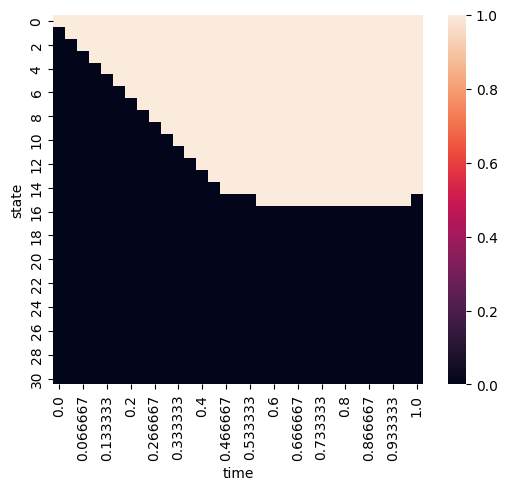

In [194]:
sns.heatmap(exercise_decisions(payoff, undertree=bondtreeT, derivtree=bondtree_dense),square=True)